# **Measuring Crime Concentration Near MBTA Stations in Boston**

Team B09: Mohamad Gong, Yanlun Li, Fei Han, Kai, Rita Feng, Abbinaya


### Executive Summary



**Purpose and Methods**

We combine Boston Police incident reports from 2016–2025 with MBTA station locations and generate 1‑, 3‑ and 5‑minute walking isochrones to measure how crime concentrates near transit. Spatial joins link incidents to these rings, and we analyze trends by offense, time, station, line and district.

**Key Findings**

- Citywide crime fell roughly 30–35 % during 2020–23 and has only partially rebounded in 2024–25.
- About 40 % of incidents occur within a five‑minute walk of stations, with the three‑minute ring carrying the largest share.
- Larceny and theft are overrepresented near stations compared with the citywide baseline.
- Stations on the Silver and Green lines—particularly Park Street, Union Park Street and Nubian—record the highest counts across all rings.
- Incidents cluster between midday and early evening on weekdays.

**Recommendations**

- Focus visible patrols and environmental improvements within the three‑minute walkshed of high‑volume transfer stations.
- Develop dashboards that integrate crime, ridership and time‑of‑day data to aid deployment decisions.
- Coordinate efforts between MBTA Transit Police and Boston Police districts around shared hotspots.
- Refresh this analysis annually to track changes and report progress.


### Problem Definition

This project measures how crime concentrates around MBTA stations in Boston and turns the results into clear, practical steps for safer transit for riders and staff. Our goal is to focus effort where it matters most and show measurable progress. Key steps include:
*   Understand where crime is higher inside the five-minute lens.
*   Compare patterns near stations with patterns outside the walksheds.
*   See when problems peak by hour, day, and season.
*   Spot which districts, stations, lines should be prioritized first.
*   Coordinate with police districts that share challenges.
*   Recommend focused actions and track shares and trends to show impact.

### Motivation



Boston’s transit network serves students across the city’s colleges, workers, and tourists daily. A view of crime near stations cuts through anecdotes, supports safety investments, and strengthens public confidence. The project also showcases geospatial methods we want to master, which are buffers, spatial joins, and risk normalization.

# **1. Data Sources**

**Crime Incident Reports:**

Incident-level reports published from the Boston Police Department's records system, documenting the initial details officers record when responding to an incident; includes offense classifications, timestamps, narrative fields, police district, and geocoded coordinates. The dataset is provided as nine separate CSV files.

**Coverage:** 2016–Sep 2025

**Format:** CSV

**Size:** 148 MB

**Link:** https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system


---


**Offense Codes Lookup:**

Lookup table mapping Boston Police Department Records Management System (RMS) offense codes to human-readable offense names; designed to decode the code fields in the Crime Incident Reports and support joins. Contains 576 records with two fields: CODE (numeric) and NAME (offense description).

**Coverage:** All offense codes currently defined in the Boston Police Department’s RMS

**Format:** XLSX

**Size:** 23 KB

**Link:** https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system


---


**MBTA Rapid Transit Stations:**

Official point locations of MBTA rapid-transit stations, maintained by MassGIS from MBTA source data; includes station names and geographic coordinates. Excludes commuter rail and bus-only stops.

**Coverage:** Current rapid-transit network

**Format:** Shapefile

**Size:** 0.21 MB

**Link:** https://www.mass.gov/info-details/massgis-data-mbta-rapid-transit


---


**Police Districts:**

Map layer of Boston Police Department district boundaries; each record has the district ID/name and boundary geometry for mapping and joins.

**Coverage:** City of Boston (current BPD districts)

**Format:** JSON

**Size:** 1.5 MB

**Link:** https://data.boston.gov/dataset/police-districts

# **2. Data Import and Cleaning**

## 2.1 Python Libraries

In [ ]:
!pip -q install contextily

In [ ]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin_nearest
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.patches import Patch
import seaborn as sns
import calendar
from google.colab import drive
from google.colab import files
from google.colab import userdata
import json, time, urllib.request, urllib.error
import contextily as cx
from shapely.geometry import box
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import textwrap

In [ ]:
# Google Drive Mounting
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## 2.2 Importing Data

In [ ]:
# Crimes Data
crimes_2023_present = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmpf72xkyya.csv", dtype={0: "string"})
crimes_2022 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmpdfeo3qy2.csv", dtype={0: "string"})
crimes_2021 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmpfap3hfze.csv", dtype={0: "string"})
crimes_2020 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmpkd_w64k_.csv", dtype={0: "string"})
crimes_2019 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmp6w6ts2d7.csv", dtype={0: "string"})
crimes_2018 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmpf_uzkqpk.csv")
crimes_2017 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmp3apxsafn.csv")
crimes_2016 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmp3ochjtdc.csv")
crimes_2015 = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/tmpzr3l5bxw.csv")
offense_codes = pd.read_excel("/content/drive/MyDrive/ba780-fall25-b09/Data/rmsoffensecodes.xlsx")

# MBTA Data
stations_geo = gpd.read_file("/content/drive/MyDrive/ba780-fall25-b09/Data/MBTA/MBTA_NODE.shp")
lines_geo = gpd.read_file("/content/drive/MyDrive/ba780-fall25-b09/Data/MBTA/MBTA_ARC.shp")

# Boundaries Data
police_polygons = gpd.read_file("/content/drive/MyDrive/ba780-fall25-b09/Data/police_districts.json")

### Data Inspection

In [ ]:
# @title
def info_many(dfs):
    for df in dfs:
        df.info()

Information of crimes tables from 2015 to present before data cleaning.

In [ ]:
info_many([crimes_2023_present, crimes_2022, crimes_2021, crimes_2020, crimes_2019, crimes_2018, crimes_2017, crimes_2016, crimes_2015])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217635 entries, 0 to 217634
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      217635 non-null  string 
 1   OFFENSE_CODE         217635 non-null  int64  
 2   OFFENSE_CODE_GROUP   0 non-null       float64
 3   OFFENSE_DESCRIPTION  217635 non-null  object 
 4   DISTRICT             217197 non-null  object 
 5   REPORTING_AREA       187128 non-null  object 
 6   SHOOTING             217635 non-null  int64  
 7   OCCURRED_ON_DATE     217635 non-null  object 
 8   YEAR                 217635 non-null  int64  
 9   MONTH                217635 non-null  int64  
 10  DAY_OF_WEEK          217635 non-null  object 
 11  HOUR                 217635 non-null  int64  
 12  UCR_PART             0 non-null       float64
 13  STREET               217635 non-null  object 
 14  Lat                  203481 non-null  float64
 15  Long             

Information of offense codes table.

In [ ]:
offense_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CODE    576 non-null    int64 
 1   NAME    576 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.1+ KB


Information of MBTA related tables.

In [ ]:
info_many([stations_geo, lines_geo])

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   170 non-null    object  
 1   LINE      170 non-null    object  
 2   TERMINUS  170 non-null    object  
 3   ROUTE     170 non-null    object  
 4   geometry  170 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 6.8+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       141 non-null    object  
 1   ROUTE      141 non-null    object  
 2   GRADE      141 non-null    int32   
 3   SHAPE_LEN  141 non-null    float64 
 4   geometry   141 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(2)
memory usage: 5.1+ KB


Information of boundaries for policing and neighborhoods.

In [98]:
police_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      12 non-null     int32   
 1   DISTRICT      12 non-null     object  
 2   ID            12 non-null     object  
 3   BPDGIS_GIS    12 non-null     object  
 4   DISTRICT_     12 non-null     int32   
 5   DISTRICT__    12 non-null     object  
 6   Shape_Length  12 non-null     float64 
 7   Shape_Area    12 non-null     float64 
 8   shape_wkt     0 non-null      object  
 9   geometry      12 non-null     geometry
dtypes: float64(2), geometry(1), int32(2), object(5)
memory usage: 996.0+ bytes


## 2.3 Data Cleaning

### Crimes Data

The first step would be to stack the crimes data from different tables into one dataframe.

In [ ]:
all_crime_data = pd.concat([crimes_2023_present, crimes_2022, crimes_2021, crimes_2020, crimes_2019, crimes_2018, crimes_2017, crimes_2016])
all_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 820942 entries, 0 to 99429
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      820942 non-null  object 
 1   OFFENSE_CODE         820942 non-null  int64  
 2   OFFENSE_CODE_GROUP   299656 non-null  object 
 3   OFFENSE_DESCRIPTION  820942 non-null  object 
 4   DISTRICT             816323 non-null  object 
 5   REPORTING_AREA       790435 non-null  object 
 6   SHOOTING             522490 non-null  object 
 7   OCCURRED_ON_DATE     820942 non-null  object 
 8   YEAR                 820942 non-null  int64  
 9   MONTH                820942 non-null  int64  
 10  DAY_OF_WEEK          820942 non-null  object 
 11  HOUR                 820942 non-null  int64  
 12  UCR_PART             299561 non-null  object 
 13  STREET               810326 non-null  object 
 14  Lat                  773662 non-null  float64
 15  Long                 77

**Crimes Types Columns Cleaning**

The list of `OFFENSE_DESCRIPTION` entries includes several offenses that are not relevant to our analysis, such as administrative violations, non-criminal incidents, and procedural or service-related reports.

In [ ]:
all_crime_data["OFFENSE_DESCRIPTION"].unique()

array(['INVESTIGATE PERSON', 'VERBAL DISPUTE', 'INVESTIGATE PROPERTY',
       'ASSAULT - AGGRAVATED',
       'DISTURBING THE PEACE/ DISORDERLY CONDUCT/ GATHERING CAUSING ANNOYANCE/ NOISY PAR',
       'THREATS TO DO BODILY HARM', 'MURDER, NON-NEGLIGENT MANSLAUGHTER',
       'SERVICE TO OTHER AGENCY', 'ASSAULT - SIMPLE',
       'WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TRAFFICKING/ OTHER',
       'HARASSMENT/ CRIMINAL HARASSMENT', 'SICK ASSIST',
       'OPERATING UNDER THE INFLUENCE (OUI) ALCOHOL',
       'LARCENY THEFT FROM BUILDING',
       'WARRANT ARREST - OUTSIDE OF BOSTON WARRANT', 'VANDALISM',
       'TRESPASSING', 'INTIMIDATING WITNESS',
       'DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE', 'ROBBERY',
       'BALLISTICS EVIDENCE/FOUND', 'LARCENY SHOPLIFTING',
       'BURGLARY - COMMERICAL',
       'WARRANT ARREST - BOSTON WARRANT (MUST BE SUPPLEMENTAL)',
       'FRAUD - IMPERSONATION', 'LARCENY ALL OTHERS',
       'BURGLARY - RESIDENTIAL', 'EXTORTION OR BLACKMAIL',
       'SI

The list of `OFFENSE_DESCRIPTION` values was reviewed and filtered using a large language model (LLM) to retain only offenses that directly impact safety, property, and transit operations, while excluding non-criminal, administrative, and procedural entries to ensure analytical focus on incidents relevant to MBTA station safety and enforcement.

In [ ]:
offense_codes_filtered = pd.read_csv("/content/drive/MyDrive/ba780-fall25-b09/Data/filtered_offense_codes.csv")
all_crime_data_filtered = all_crime_data[all_crime_data["OFFENSE_CODE"].isin(offense_codes_filtered['CODE'])]
all_crime_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325121 entries, 4 to 99426
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      325121 non-null  object 
 1   OFFENSE_CODE         325121 non-null  int64  
 2   OFFENSE_CODE_GROUP   126833 non-null  object 
 3   OFFENSE_DESCRIPTION  325121 non-null  object 
 4   DISTRICT             323495 non-null  object 
 5   REPORTING_AREA       314282 non-null  object 
 6   SHOOTING             199206 non-null  object 
 7   OCCURRED_ON_DATE     325121 non-null  object 
 8   YEAR                 325121 non-null  int64  
 9   MONTH                325121 non-null  int64  
 10  DAY_OF_WEEK          325121 non-null  object 
 11  HOUR                 325121 non-null  int64  
 12  UCR_PART             126823 non-null  object 
 13  STREET               321544 non-null  object 
 14  Lat                  308042 non-null  float64
 15  Long                 30

Inspection of the `OFFENSE_CODE_GROUP` column reveals that some records share the same offense code and group, but the group value is missing in others.

In [ ]:
all_crime_data_filtered.groupby(['OFFENSE_CODE', 'OFFENSE_CODE_GROUP'], dropna=False).size().reset_index().sort_values(['OFFENSE_CODE','OFFENSE_CODE_GROUP'])

,OFFENSE_CODE,OFFENSE_CODE_GROUP,0
0,111,Homicide,193
1,111,NaN,222
2,301,Robbery,2648
3,301,NaN,4969
4,311,Robbery,541
...,...,...,...
182,2672,NaN,1
183,3119,Firearm Discovery,575
184,3119,NaN,1144
185,3203,Firearm Discovery,10


Missing values in the `OFFENSE_CODE_GROUP` column can be imputed using information from complete records with the same offense code.

In [ ]:
all_crime_data_filtered['OFFENSE_CODE_GROUP'] = all_crime_data_filtered['OFFENSE_CODE_GROUP'].fillna(all_crime_data_filtered.groupby('OFFENSE_CODE')['OFFENSE_CODE_GROUP'].transform('first'))
all_crime_data_filtered.info()

/tmp/ipython-input-4099435155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_crime_data_filtered['OFFENSE_CODE_GROUP'] = all_crime_data_filtered['OFFENSE_CODE_GROUP'].fillna(all_crime_data_filtered.groupby('OFFENSE_CODE')['OFFENSE_CODE_GROUP'].transform('first'))


<class 'pandas.core.frame.DataFrame'>
Index: 325121 entries, 4 to 99426
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      325121 non-null  object 
 1   OFFENSE_CODE         325121 non-null  int64  
 2   OFFENSE_CODE_GROUP   325121 non-null  object 
 3   OFFENSE_DESCRIPTION  325121 non-null  object 
 4   DISTRICT             323495 non-null  object 
 5   REPORTING_AREA       314282 non-null  object 
 6   SHOOTING             199206 non-null  object 
 7   OCCURRED_ON_DATE     325121 non-null  object 
 8   YEAR                 325121 non-null  int64  
 9   MONTH                325121 non-null  int64  
 10  DAY_OF_WEEK          325121 non-null  object 
 11  HOUR                 325121 non-null  int64  
 12  UCR_PART             126823 non-null  object 
 13  STREET               321544 non-null  object 
 14  Lat                  308042 non-null  float64
 15  Long                 30

**Spatial Columns Cleaning**

Since this is a spatial analysis, the next step is to verify whether the coordinates field contains missing values and how those missing values distribute across districts before we drop them.

In [ ]:
missing_coords = all_crime_data_filtered["Location"].isna()
null_count = int(missing_coords.sum())
total_count = len(all_crime_data_filtered)
percentage_null = (null_count / total_count) * 100

print(f"Missing coordinates: {null_count} of {total_count} rows "
      f"({percentage_null:.2f}% missing)")

Missing coordinates: 17079 of 325121 rows (5.25% missing)


The dataset has 17,079 rows without coordinates out of 325,121 total (5.25% missing). This is a small share, so if the missingness is roughly even across districts, dropping these rows should have minimal impact on overall spatial patterns. If any district shows a noticeably higher missing rate, we may need to note that bias before removal or revisit upstream geocoding.

In [ ]:
percentage_by_district = (all_crime_data_filtered.groupby("DISTRICT", dropna=False)["Location"].apply(lambda s: s.isna().mean() * 100))
summary_district = (percentage_by_district.describe().to_frame(name="percentage_missing_district").round(2))
print(percentage_by_district, summary_district)

DISTRICT
A1            11.163105
A15            3.718459
A7             3.899409
B2             4.466985
B3             4.950144
C11            2.822450
C6             7.379479
D14            2.641989
D4             4.385239
E13            3.216459
E18            3.132530
E5             2.682779
External      27.574751
Outside of     0.000000
NaN           35.916359
Name: Location, dtype: float64        percentage_missing_district
count                        15.00
mean                          7.86
std                          10.13
min                           0.00
25%                           2.98
50%                           3.90
75%                           6.16
max                          35.92


Missing coordinates are low and fairly even across real districts (median 3.90%, IQR 2.98% to 6.16%). A1 (11.16%) and C6 (7.38%) are somewhat higher but still modest. The highest rates are in edge buckets, External (27.57%) and NaN (35.92%), which inflate the mean.

In [ ]:
all_crime_data_clean = all_crime_data_filtered.dropna(subset = "Location")

Since October 2025 is not yet complete in the source data, all October 2025 records are excluded from the analysis.

In [ ]:
all_crime_data_clean = all_crime_data_clean[~((all_crime_data_clean.YEAR == 2025) & (all_crime_data_clean.MONTH == 10))]
all_crime_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307975 entries, 4 to 99426
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      307975 non-null  object 
 1   OFFENSE_CODE         307975 non-null  int64  
 2   OFFENSE_CODE_GROUP   307975 non-null  object 
 3   OFFENSE_DESCRIPTION  307975 non-null  object 
 4   DISTRICT             306933 non-null  object 
 5   REPORTING_AREA       297797 non-null  object 
 6   SHOOTING             189276 non-null  object 
 7   OCCURRED_ON_DATE     307975 non-null  object 
 8   YEAR                 307975 non-null  int64  
 9   MONTH                307975 non-null  int64  
 10  DAY_OF_WEEK          307975 non-null  object 
 11  HOUR                 307975 non-null  int64  
 12  UCR_PART             119575 non-null  object 
 13  STREET               307204 non-null  object 
 14  Lat                  307975 non-null  float64
 15  Long                 30

### MBTA Data

In [ ]:
info_many([stations_geo, lines_geo])

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   170 non-null    object  
 1   LINE      170 non-null    object  
 2   TERMINUS  170 non-null    object  
 3   ROUTE     170 non-null    object  
 4   geometry  170 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 6.8+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       141 non-null    object  
 1   ROUTE      141 non-null    object  
 2   GRADE      141 non-null    int32   
 3   SHAPE_LEN  141 non-null    float64 
 4   geometry   141 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(2)
memory usage: 5.1+ KB


After inspecting the dataframe, we convert stations and lines to a local projected CRS (EPSG:26986) for accurate nearest matching, spatially join each station to the closest line to bring over the line’s GRADE, switch stations back to WGS84 (EPSG:4326), drop the geometry to make a flat table, and extract lon and lat from the geometry before previewing the result.

In [ ]:
stations_geo = stations_geo.to_crs(epsg=26986)
lines_geo = lines_geo.to_crs(epsg=26986)

stations_geo = gpd.sjoin_nearest(stations_geo, lines_geo[["GRADE", "geometry"]])

stations_geo = stations_geo.to_crs(epsg=4326)

stations_data = stations_geo.drop(columns="geometry").copy()
stations_data["lon"] = stations_geo.geometry.x
stations_data["lat"] = stations_geo.geometry.y

stations_data.head(3)

,STATION,LINE,TERMINUS,ROUTE,index_right,GRADE,lon,lat
0,Park Street,GREEN/RED,N,GREEN B C D E / RED A - Ashmont B - Braintree...,19,7,-71.062245,42.356306
1,JFK/UMass,RED,N,A - Ashmont B - Braintree C - Alewife,118,1,-71.052361,42.320637
2,State,BLUE/ORANGE,N,BLUE Bowdoin to Wonderland / ORANGE Forest Hil...,107,7,-71.057819,42.358799


In [ ]:
stations_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 0 to 169
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATION      195 non-null    object 
 1   LINE         195 non-null    object 
 2   TERMINUS     195 non-null    object 
 3   ROUTE        195 non-null    object 
 4   index_right  195 non-null    int64  
 5   GRADE        195 non-null    int32  
 6   lon          195 non-null    float64
 7   lat          195 non-null    float64
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 12.9+ KB


# **3. Analysis and Findings**

## 3.1 Overall Crime Analysis

*How does crime trend across Boston?*

To set context we first examine year‑over‑year crime patterns across the city.


We first look at a citywide overview of year-over-year crime trends in Boston.

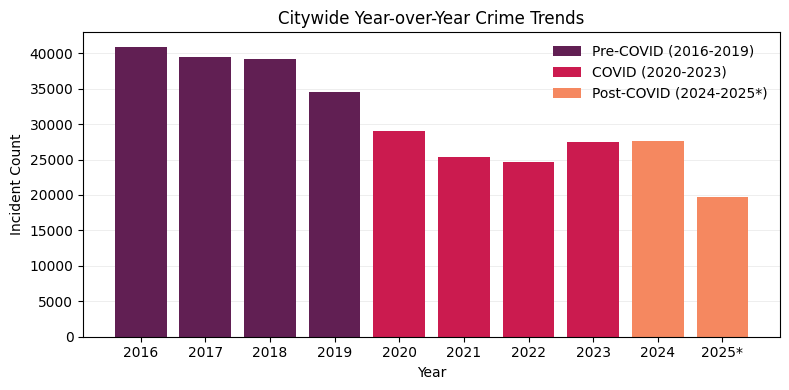

*2025 is year-to-date; counts are not directly comparable to full years.


In [ ]:
full_years = np.arange(2016, 2026)

yearly = (all_crime_data_clean['YEAR']
          .value_counts()
          .sort_index()
          .reindex(full_years, fill_value=0))

years = yearly.index.astype(int).values
vals  = yearly.values

fig, ax = plt.subplots(figsize=(8, 4))

m_pre   = (years >= 2016) & (years <= 2019)
m_covid = (years >= 2020) & (years <= 2023)
m_post  = (years >= 2024) & (years <= 2025)

pal = sns.color_palette("rocket", 3)
c_pre, c_covid, c_post = pal[0], pal[1], pal[2]

ax.bar(years[m_pre],   vals[m_pre],   color=c_pre,   label='Pre-COVID (2016-2019)')
ax.bar(years[m_covid], vals[m_covid], color=c_covid, label='COVID (2020-2023)')
ax.bar(years[m_post],  vals[m_post],  color=c_post,  label='Post-COVID (2024-2025*)')

ax.set_xticks(years)
ax.set_xticklabels([f'{y}*' if y == 2025 else str(y) for y in years])
ax.set_xlabel('Year')
ax.set_ylabel('Incident Count')
ax.set_title('Citywide Year-over-Year Crime Trends')
ax.legend(frameon=False, loc='best')

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()
print("*2025 is year-to-date; counts are not directly comparable to full years.")

From the chart we were able to:
*   Quantify a material contraction in incident volume after 2019, down approximately 30 to 35 percent during 2020 to 2023, aligned with reduced mobility and activity in the pandemic period.
*   Confirm a measured recovery in 2024 that remains below the 2016 to 2019 baseline, indicating a sustained step-down rather than a full rebound.

We next look at the composition of crime across offense categories to establish a citywide baseline. This helps identify which types of incidents dominate overall activity and provides reference proportions for later near-station comparisons.

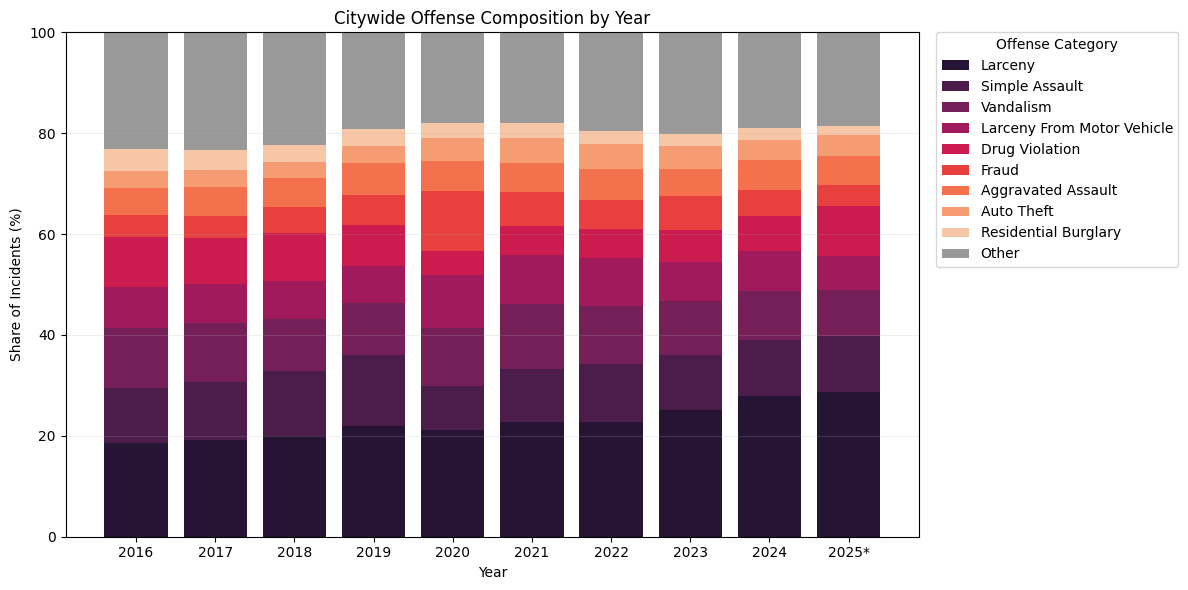

*2025 is year to date; counts are not directly comparable to full years.


In [ ]:
df = all_crime_data_clean.copy()
df["OFFENSE_CODE_GROUP"] = df["OFFENSE_CODE_GROUP"].fillna("Unknown")

overall = df.groupby("OFFENSE_CODE_GROUP").size().sort_values(ascending=False)
top9 = overall.drop(labels=["Other"], errors="ignore").head(9).index.tolist()
OTHER_LABEL = "Other"

df["OFFENSE_TOP9"] = np.where(df["OFFENSE_CODE_GROUP"].isin(top9), df["OFFENSE_CODE_GROUP"], OTHER_LABEL)

years_present = sorted(df["YEAR"].dropna().astype(int).unique().tolist())
year_min, year_max = min(years_present), max(years_present)
all_years = list(range(year_min, year_max + 1))

cols_order = top9 + [OTHER_LABEL]

counts = (df.groupby(["YEAR","OFFENSE_TOP9"]).size()
            .unstack(fill_value=0)
            .reindex(index=all_years, columns=cols_order, fill_value=0))

pct = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0) * 100

plt.figure(figsize=(12,6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

colors_top9 = sns.color_palette("rocket", n_colors=len(top9))
color_map = {g: colors_top9[i] for i, g in enumerate(top9)}
color_map[OTHER_LABEL] = (0.6, 0.6, 0.6)

for g in cols_order:
    vals = pct[g].values
    plt.bar(x, vals, bottom=bottom, label=g, color=color_map[g])
    bottom += vals

labels = [f"{y}*" if y == 2025 else str(y) for y in pct.index]
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.ylabel("Share of Incidents (%)")
plt.xlabel("Year")
plt.title("Citywide Offense Composition by Year")
plt.grid(axis="y", alpha=0.2)
plt.legend(title="Offense Category", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()
print("*2025 is year to date; counts are not directly comparable to full years.")

From the chart we were able to:
*   Larceny is the dominant category and has expanded its share of incidents, moving from roughly 19 to 22 percent before 2019 to about 27 to 30 percent by 2024 to 2025*, indicating growing concentration in theft-related activity.
*   The mix has become more top heavy as Drug Violation and Fraud receded from their 2020 peak toward 2023 to 2025, while categories like Simple Assault and Vandalism held relatively steady and the residual Other bucket shrank.

We next look at the distribution of incidents across weekdays and hours of the day to capture the citywide temporal fingerprint. This baseline pattern helps interpret later near-station analyses by showing when crime activity typically peaks.

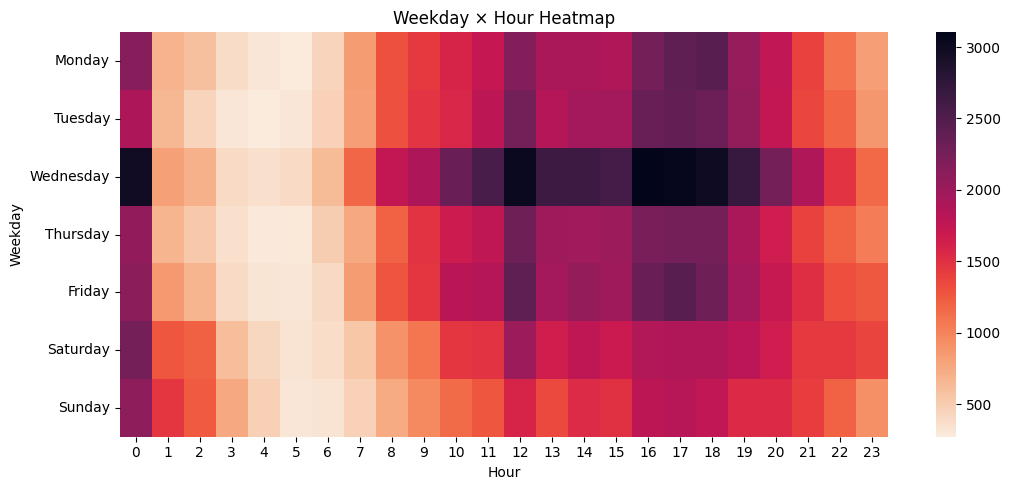

In [ ]:
wk_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

tmp = all_crime_data_clean.copy()
tmp["DAY_OF_WEEK"] = pd.Categorical(tmp["DAY_OF_WEEK"], categories=wk_order, ordered=True)

mat = (tmp.groupby(["DAY_OF_WEEK","HOUR"], observed=False)
         .size()
         .unstack(fill_value=0)
         .reindex(wk_order)
         .reindex(columns=range(24), fill_value=0))

plt.figure(figsize=(11,5))
sns.heatmap(mat, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.title("Weekday × Hour Heatmap")
plt.xlabel("Hour"); plt.ylabel("Weekday")
plt.tight_layout(); plt.show()

From the chart we were able to:
*  Identify a strong diurnal pattern, with incident activity concentrated between late morning and early evening, peaking around midday to 6 p.m., which aligns with periods of highest citywide mobility and commercial activity.
*   Observe relatively consistent weekday patterns, with Wednesday showing the highest overall volume and weekend days (Saturday and Sunday) exhibiting a more diffuse distribution of incidents across daytime and evening hours.

## 3.2 Crime in Relation to MBTA Stations

*How concentrated is crime near MBTA stations?*

We analyze crime patterns relative to the 1‑, 3‑ and 5‑minute walksheds to measure concentration.


We generate 1, 3, 5-minute walking isochrone polygons for every MBTA station using the Mapbox Isochrone API, then save the result as a single GeoJSON for reuse.

In [ ]:
#MAPBOX_TOKEN = userdata.get("MBox")
#
#features = []
#for i, row in stations_data.reset_index(drop=True).iterrows():
#    lon = float(row["lon"]); lat = float(row["lat"])
#    url = (
#        f"https://api.mapbox.com/isochrone/v1/mapbox/walking/"
#        f"{lon},{lat}?contours_minutes=1,3,5&polygons=true&access_token={MAPBOX_TOKEN}"
#    )
#
#    if i > 0:
#        time.sleep(0.25)
#
#    for attempt in range(5):
#        try:
#            with urllib.request.urlopen(url, timeout=60) as resp:
#                fc_resp = json.loads(resp.read().decode("utf-8"))
#            break
#        except urllib.error.HTTPError as e:
#            if e.code == 429:
#                time.sleep(2 * (attempt + 1))
#                continue
#            else:
#                raise
#
#    for f in fc_resp.get("features", []):
#        p = f.get("properties", {})
#        p["STATION"] = row["STATION"]
#        p["LINE"] = row["LINE"]
#        p["MINUTES"] = int(p.get("contour", 0))
#        f["properties"] = p
#        features.append(f)
#
#fc = {"type": "FeatureCollection", "features": features}
#isochrones_gdf = (
#    gpd.GeoDataFrame.from_features(fc, crs="EPSG:4326")
#      .sort_values(["STATION","MINUTES"])
#      .reset_index(drop=True)
#)

In [ ]:
#OUTPUT_PATH = "mapbox_isochrones_mbta_1_3_5min.geojson"
#with open(OUTPUT_PATH, "w") as f:
#    json.dump(fc, f)
#
#files.download(OUTPUT_PATH)

**Note:** The two Mapbox isochrone cells above are commented out so that running the entire notebook won’t trigger new API calls. Use the saved GeoJSON instead.

In [ ]:
isochrones_gdf = gpd.read_file("/content/drive/MyDrive/ba780-fall25-b09/Data/mapbox_isochrones_mbta_1_3_5min.geojson")
isochrones_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   fill-opacity  585 non-null    float64 
 1   fillColor     585 non-null    object  
 2   opacity       585 non-null    float64 
 3   fill          585 non-null    object  
 4   fillOpacity   585 non-null    float64 
 5   color         585 non-null    object  
 6   contour       585 non-null    int32   
 7   metric        585 non-null    object  
 8   STATION       585 non-null    object  
 9   LINE          585 non-null    object  
 10  MINUTES       585 non-null    int32   
 11  geometry      585 non-null    geometry
dtypes: float64(3), geometry(1), int32(2), object(6)
memory usage: 50.4+ KB


This step links each crime record to a station and walking zone using isochrone polygons (1, 3, 5 minutes).
Rules:
*   Pick the smallest segment that contains the incident (1, then 3, then 5 minutes).
*   If more than one station contains the point, pick the nearest station (Euclidean distance).
*   If no polygon contains the point, label it as “outside”.

The new columns `walk_segment` and `station_owner` support later analysis of coverage and proximity effects.

In [ ]:
df = all_crime_data_clean.copy()
df['rowid'] = np.arange(len(df))

crimes_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Long, df.Lat),
    crs=4326
)

iso_poly = isochrones_gdf[['STATION','MINUTES','geometry']].copy()
stations_df = stations_data[['STATION','lon','lat']].reset_index().rename(columns={'index':'station_id'})
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.lon, stations_df.lat),
    crs=4326
)

j = gpd.sjoin(crimes_gdf[['rowid','geometry']], iso_poly, how='left', predicate='within')
mins = j.groupby('rowid', as_index=False)['MINUTES'].min().rename(columns={'MINUTES':'min_minutes'})
cand = j.merge(mins, on='rowid', how='left')
cand = cand[cand['MINUTES'].eq(cand['min_minutes'])].merge(stations_gdf[['STATION','station_id']], on='STATION', how='left')

crimes_m = crimes_gdf.to_crs(3857)[['rowid','geometry']].rename(columns={'geometry':'crime_geom'})
stations_m = stations_gdf.to_crs(3857)[['station_id','geometry']].rename(columns={'geometry':'station_geom'})

cand = cand.merge(crimes_m, on='rowid', how='left').merge(stations_m, on='station_id', how='left')
cand['dist'] = cand['crime_geom'].distance(cand['station_geom'])
cand = cand.sort_values(['rowid','dist','station_id']).drop_duplicates('rowid', keep='first')

walk_segment = np.full(len(df), 'outside', dtype=object)
station_owner = np.full(len(df), np.nan, dtype=object)

idx = cand['rowid'].to_numpy()
walk_segment[idx] = cand['MINUTES'].astype(str).to_numpy()
station_owner[idx] = cand['STATION'].to_numpy()

all_crime_data_clean['walk_segment'] = walk_segment
all_crime_data_clean['station_owner'] = station_owner

This view quantifies total incidents by year and shows how activity is distributed across the 1-, 3-, and 5-minute station walks relative to the rest of the city. It provides both absolute volumes and within-year shares to assess how each ring’s contribution shifts over time.

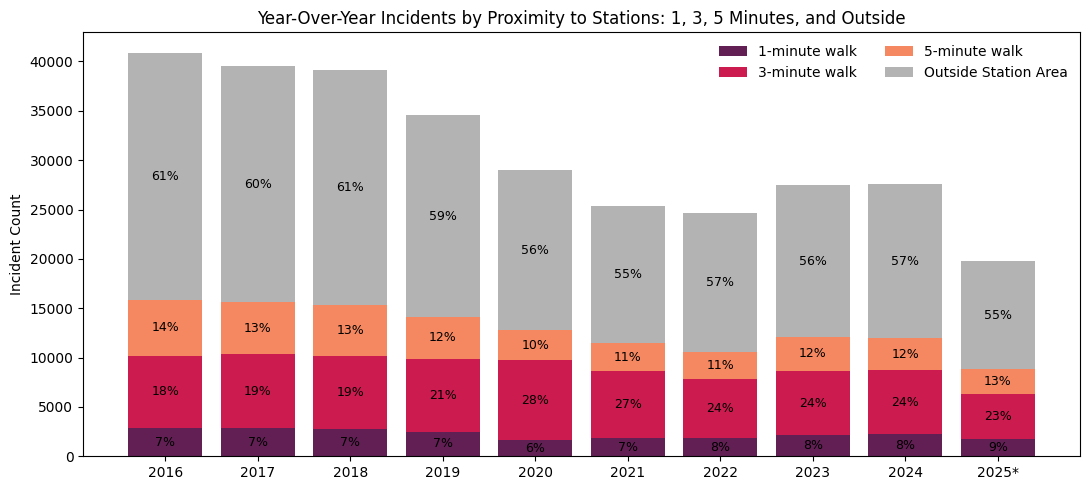

*2025 is year to date; counts are not directly comparable to full years.


In [ ]:
df = all_crime_data_clean.copy()

ring_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk","outside":"Outside Station Area"}
df["ring_label"] = df["walk_segment"].astype(str).map(ring_map)

year_order = sorted(df["YEAR"].dropna().astype(int).unique().tolist())
ring_order  = ["1-minute walk","3-minute walk","5-minute walk","Outside Station Area"]

pal = sns.color_palette("rocket", 3)
c1, c3, c5 = pal[0], pal[1], pal[2]
c_out = (0.7, 0.7, 0.7)
color_map = {
    "1-minute walk": c1,
    "3-minute walk": c3,
    "5-minute walk": c5,
    "Outside Station Area": c_out
}

counts = (df.groupby(["YEAR","ring_label"]).size()
            .unstack(fill_value=0)
            .reindex(index=year_order, columns=ring_order, fill_value=0))

totals = counts.sum(axis=1)
pct = counts.div(totals.replace(0, np.nan), axis=0) * 100

x = np.arange(len(year_order))
width = 0.8
bottom = np.zeros(len(year_order))

fig, ax = plt.subplots(figsize=(11,5))
for seg in ring_order:
    vals = counts[seg].values
    ax.bar(x, vals, bottom=bottom, label=seg, color=color_map[seg], width=width)
    # annotate percent on the segment
    seg_pct = pct[seg].values
    for xi, v, b, p in zip(x, vals, bottom, seg_pct):
        if v > 0 and p >= 5:
            ax.text(xi, b + v/2, f"{p:.0f}%", ha="center", va="center", fontsize=9)
    bottom += vals

labels = [f"{y}*" if y == 2025 else str(y) for y in year_order]
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel("Incident Count")
ax.set_title("Year-Over-Year Incidents by Proximity to Stations: 1, 3, 5 Minutes, and Outside")
ax.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()
print("*2025 is year to date; counts are not directly comparable to full years.")

From the stacked bars we can see how total volume and the within-year distribution across rings evolved.
*   Station-area share increased relative to the 2016 to 2019 baseline, rising from about 39 to 41 percent pre-COVID to roughly 43 to 45 percent in 2023 to 2025*.
*   The 3-minute ring carries most in-shed volume at about 23 to 28 percent, the 1-minute ring is small but steady at about 6 to 9 percent, and the 5-minute ring holds about 10 to 14 percent.

This chart shows the incremental incidents captured as we expand outward from stations (1 → 3 → 5 minutes → outside) and the cumulative share captured after each step. It highlights whether additional area yields proportionate incident capture as we expand outward.

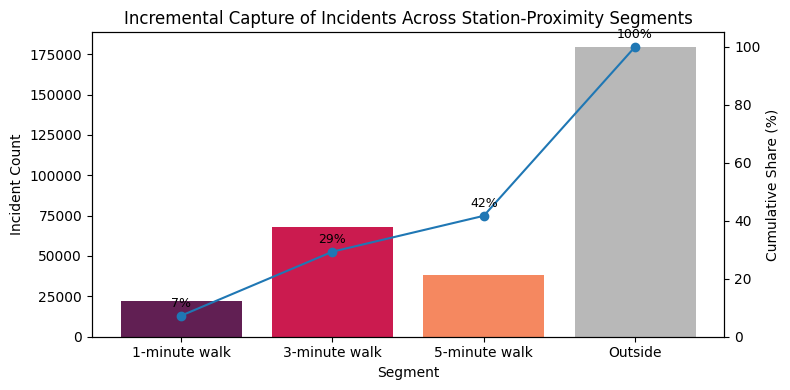

In [ ]:
df = all_crime_data_clean.copy()

ring_labels = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk","outside":"Outside"}
order = ["1-minute walk","3-minute walk","5-minute walk","Outside"]

df = df[df["walk_segment"].astype(str).isin(["1.0","3.0","5.0","outside"])].copy()
df["ring_label"] = df["walk_segment"].astype(str).map(ring_labels)

pal = sns.color_palette("rocket", 3)
ring_colors = {
    "1-minute walk": pal[0],
    "3-minute walk": pal[1],
    "5-minute walk": pal[2],
    "Outside": (0.72, 0.72, 0.72),
}

agg = (df.groupby("ring_label").size()
         .reindex(order)
         .rename("count"))
cum = agg.cumsum()
cum_pct = cum / agg.sum() * 100

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.bar(agg.index, agg.values, color=[ring_colors[k] for k in agg.index])
ax1.set_ylabel("Incident Count")
ax1.set_xlabel("Segment")
ax1.set_title("Incremental Capture of Incidents Across Station-Proximity Segments")

ax2 = ax1.twinx()
ax2.plot(agg.index, cum_pct.values, marker="o")
ax2.set_ylabel("Cumulative Share (%)")
ax2.set_ylim(0, 105)

for xi, yi in zip(range(len(cum_pct)), cum_pct.values):
    ax2.text(xi, yi+2, f"{yi:.0f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

This Pareto view shows the marginal contribution of each expansion step and the cumulative share captured.
*   Expanding from 1 to 3 minutes delivers the largest gain, moving cumulative capture from 7 percent to 29 percent, a 22-point step.
*   Extending to 5 minutes raises capture to 42 percent, indicating diminishing returns beyond 3 minutes, with the remaining 58 percent occurring outside station walksheds.

These small multiples profile offense composition within each segment. By comparing the top offense categories within each ring, we can see which offense types are most station-proximate and whether composition shifts as we move outward.

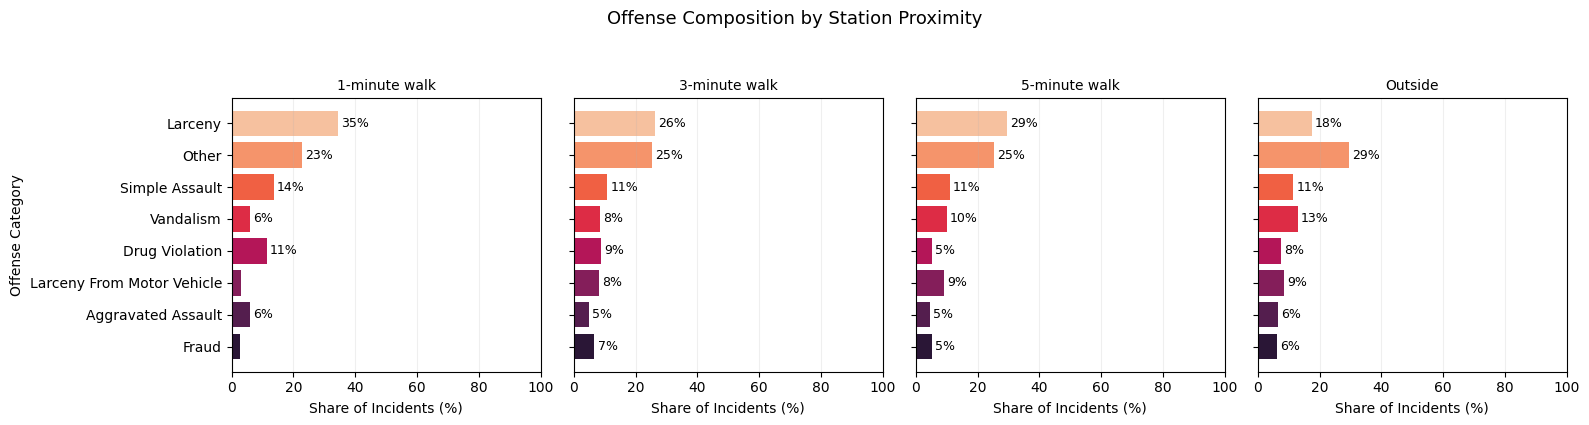

In [ ]:
dff = all_crime_data_clean.copy()

ring_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk","outside":"Outside"}
dff = dff[dff["walk_segment"].isin(ring_map.keys())].copy()
dff["ring_label"] = dff["walk_segment"].map(ring_map)

dff["OFFENSE_CODE_GROUP"] = dff["OFFENSE_CODE_GROUP"].fillna("Unknown")


top_overall = (dff.groupby("OFFENSE_CODE_GROUP").size()
                 .sort_values(ascending=False)
                 .head(8).index.tolist())
dff["OFFENSE_TOP"] = np.where(dff["OFFENSE_CODE_GROUP"].isin(top_overall),
                              dff["OFFENSE_CODE_GROUP"], "Other")

seg_list = ["1-minute walk","3-minute walk","5-minute walk","Outside"]

comp = (dff.groupby(["ring_label","OFFENSE_TOP"]).size()
          .unstack(fill_value=0)
          .reindex(index=seg_list, fill_value=0))

share = comp.div(comp.sum(axis=1).replace(0, np.nan), axis=0) * 100

global_share = share.sum(axis=0)
cat_order = list(global_share.sort_values(ascending=True).index)
share = share.reindex(columns=cat_order)

cat_palette = sns.color_palette("rocket", n_colors=len(cat_order))
cat_color_map = {cat: cat_palette[i] for i, cat in enumerate(cat_order)}

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for ax, seg in zip(axes, seg_list):
    s = share.loc[seg].astype(float)
    colors = [cat_color_map[c] for c in s.index]
    ax.barh(s.index, s.values, color=colors)
    ax.set_xlim(0, 100)
    ax.invert_yaxis()
    ax.grid(axis="x", alpha=0.2)
    for yi, (name, val) in enumerate(s.items()):
        if np.isfinite(val) and val >= 4:
            ax.text(val + 1, yi, f"{val:.0f}%", va="center", fontsize=9)
    ax.set_xlabel("Share of Incidents (%)")
    ax.set_ylabel("Offense Category" if ax is axes[0] else "")
    ax.text(0.5, 1.02, seg, transform=ax.transAxes, ha="center", va="bottom", fontsize=10)

fig.suptitle("Offense Composition by Station Proximity", y=1.05, fontsize=13)
plt.tight_layout()
plt.show()

These facets compare category shares within each segment to identify which offenses are most station-proximate.
*   Larceny is most concentrated near stations, reaching about 35 percent in the 1-minute ring versus about 18 percent outside.
*   Violent categories and vandalism show weaker gradients by proximity, and the Other bucket is larger outside, indicating a more diffuse mix away from stations.

## 3.3 MBTA Station and Line Analysis

*Which stations and lines have the most crime?*

We rank lines and stations by incident counts across the different ring sizes.


This chapter examines variation across lines and stations. We compare totals and per-station intensity by line, surface leaders under different catchment sizes, test whether hourly peaks shift with segment size, contrast weekday vs weekend patterns for a priority set, and assess inequality of risk with Lorenz curves.

Contrasts total incidents by line within the 1, 3, and 5 minute walksheds to reveal which lines contribute the most volume at each proximity.

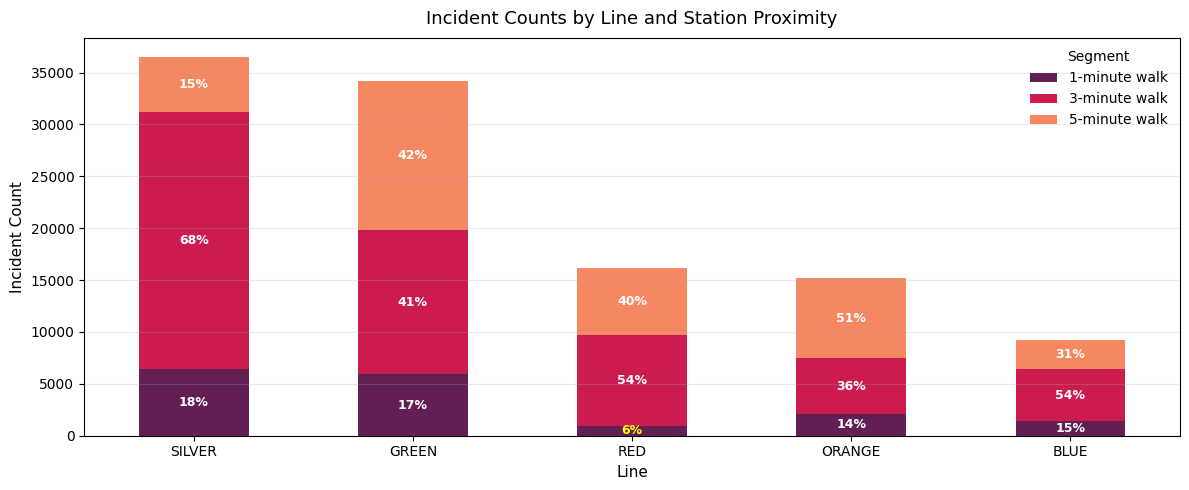

In [ ]:
df = all_crime_data_clean.copy()
ring_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk"}
df = df[df["walk_segment"].isin(ring_map.keys())].copy()
df["segment"] = df["walk_segment"].map(ring_map)
df = df[df["station_owner"].notna()].copy()
df["station_owner_norm"] = df["station_owner"].str.strip()

sd = stations_data.copy()
sd["STATION_norm"] = sd["STATION"].str.strip()
line_per_station = sd.groupby("STATION_norm")["LINE"].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
df["LINE"] = df["station_owner_norm"].map(line_per_station).fillna("Unmapped").str.upper()
df = df[~df["LINE"].str.contains("/")].copy()

seg_order = ["1-minute walk","3-minute walk","5-minute walk"]
seg_colors = dict(zip(seg_order, sns.color_palette("rocket", 3)))

counts = (df.groupby(["LINE","segment"]).size().rename("count").reset_index())
wide = (counts.pivot(index="LINE", columns="segment", values="count")
              .reindex(columns=seg_order).fillna(0))

line_order = ["SILVER","GREEN","RED","ORANGE","BLUE"]
wide = wide.reindex(index=[l for l in line_order if l in wide.index])

fig, ax = plt.subplots(figsize=(12,5))
wide.plot(kind="bar", stacked=True, ax=ax,
          color=[seg_colors[s] for s in seg_order], edgecolor="none")

ax.set_title("Incident Counts by Line and Station Proximity", fontsize=13, pad=10)
ax.set_xlabel("Line", fontsize=11)
ax.set_ylabel("Incident Count", fontsize=11)
ax.legend(title="Segment", frameon=False, loc="upper right")
ax.grid(axis="y", alpha=0.25)
plt.xticks(rotation=0)
plt.tight_layout()

row_tot = wide.sum(axis=1).replace(0, np.nan)
containers = ax.containers[:len(seg_order)]
for cont, seg in zip(containers, seg_order):
    pcts = (wide[seg].div(row_tot) * 100).fillna(0).to_numpy()
    for rect, pct in zip(cont.patches, pcts):
        h = rect.get_height()
        if h > 0:
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_y() + h/2,
                    f"{pct:.0f}%",
                    ha="center", va="center",
                    fontsize=9,
                    color=("white" if pct >= 7 else "yellow"),
                    fontweight="bold")

plt.show()

This figure shows which lines contribute the most incidents within the 1, 3, and 5 minute walksheds.
*   Silver Line and Green Line show the highest total incident counts

*   In general, 3-minute walking zones dominate across all lines — indicating that most incidents occur slightly away from immediate station entrances but still within close proximity.

*   The 1-minute zone contributes the smallest share of incidents on all lines — around 6–18%, suggesting stations themselves are less crime-dense than their near surroundings.

Normalizes by the number of stations on each line to compare intensity per station across the 1, 3, and 5 minute walksheds.

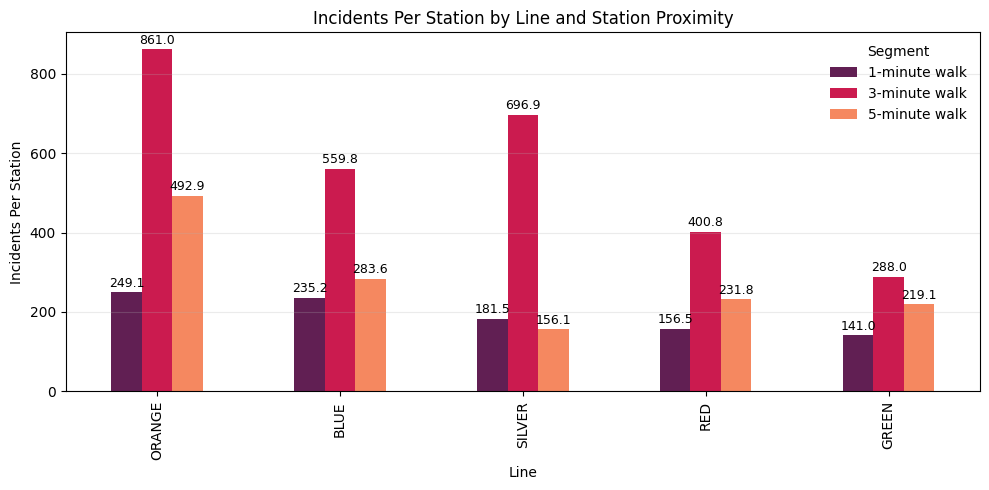

In [ ]:
sd = stations_data.copy()
sd["STATION_norm"] = sd["STATION"].str.strip()

station_line = (
    sd[["STATION_norm", "LINE"]]
      .dropna(subset=["LINE"])
      .assign(
          LINE=lambda d: (
              d["LINE"].astype(str)
               .str.upper()
               .str.replace(r"\s+", "", regex=True)
               .str.split("/")
          )
      )
      .explode("LINE")
      .drop_duplicates(["STATION_norm", "LINE"])
)

df = all_crime_data_clean.copy()
ring_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk"}
df = df[df["walk_segment"].isin(ring_map.keys())].copy()
df["segment"] = df["walk_segment"].map(ring_map)
df = df[df["station_owner"].notna()].copy()
df["station_owner_norm"] = df["station_owner"].str.strip()

dfL = (df.merge(station_line, left_on="station_owner_norm", right_on="STATION_norm", how="left")
         .dropna(subset=["LINE"]))

n_stations = (station_line.groupby("LINE")["STATION_norm"]
                           .nunique()
                           .rename("n_stations"))

counts = (dfL.groupby(["LINE", "segment"]).size()
            .rename("count").reset_index()
            .merge(n_stations, on="LINE", how="left"))

counts["per_station"] = counts["count"] / counts["n_stations"].replace(0, np.nan)

seg_order = ["1-minute walk","3-minute walk","5-minute walk"]


wide = (counts.pivot(index="LINE", columns="segment", values="per_station")
              .reindex(columns=seg_order)
              .fillna(0))

line_order = (counts.groupby("LINE")["per_station"]
                      .sum()
                      .sort_values(ascending=False)
                      .index.tolist())
wide = wide.reindex(index=line_order)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
wide.plot(kind="bar", ax=ax, color=[seg_colors[s] for s in seg_order])
ax.set_title("Incidents Per Station by Line and Station Proximity")
ax.set_xlabel("Line"); ax.set_ylabel("Incidents Per Station")
ax.legend(title="Segment", frameon=False)
ax.grid(axis="y", alpha=0.25)
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v:.1f}" if v > 0 else "" for v in container.datavalues],
        fmt="%.1f",
        label_type="edge",
        fontsize=9,
        padding=2
    )

plt.tight_layout(); plt.show()

This figure normalizes by the number of stations to compare intensity per station.
*  Green Line – Although it records the second-highest total crime count, it has the lowest average crimes per station. This suggests that the Green Line’s extensive station network distributes incidents more evenly, lowering per-station intensity and indicating a wider but less concentrated crime pattern.

*  Silver Line – It shows the highest values in both total crimes and average crimes per station, implying a high passenger concentration and potentially greater exposure to risk. The data may also reflect this line’s popularity and higher traffic volume, which can naturally correlate with elevated incident frequency.
*   The 3 minute ring remains the most productive proximity band for intensity.


Ranks the top stations separately for the 1, 3, and 5 minute walksheds to show how leaders change as the catchment expands.

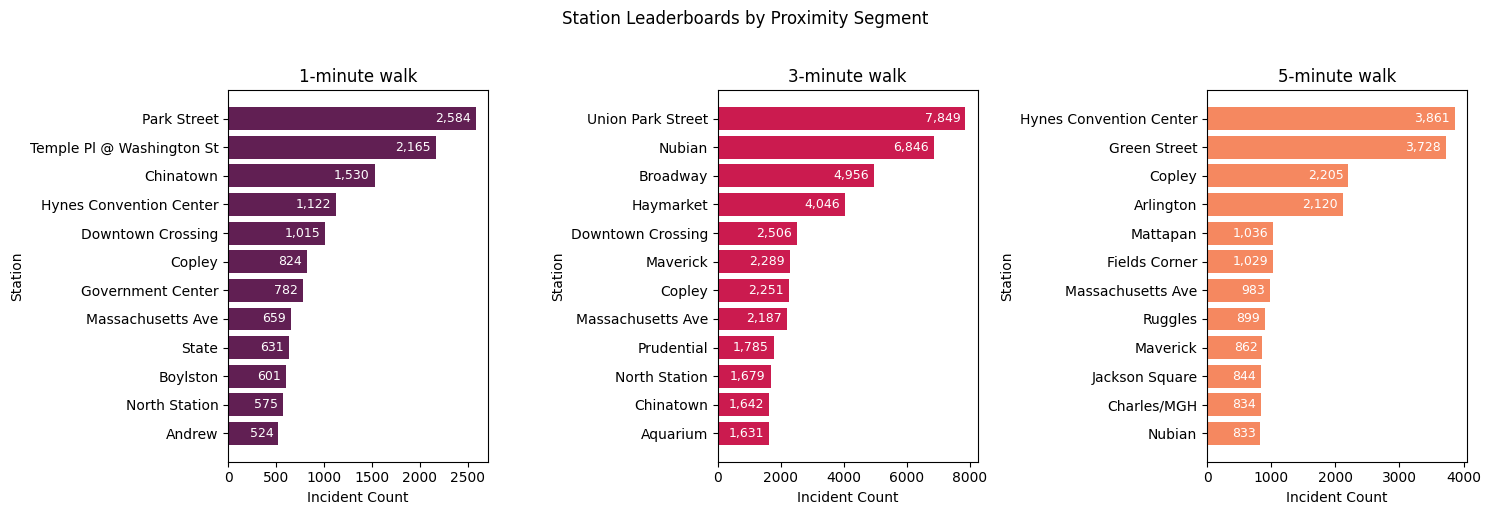

In [ ]:
df = all_crime_data_clean.copy()
ring_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk"}
df = df[df["walk_segment"].isin(ring_map.keys())].copy()
df["segment"] = df["walk_segment"].map(ring_map)

seg_order = ["1-minute walk","3-minute walk","5-minute walk"]
pal = sns.color_palette("rocket", 3)
seg_colors = dict(zip(seg_order, pal))

top_n = 12
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=False)

for ax, seg in zip(axes, seg_order):
    sub = df[df["segment"]==seg].groupby("station_owner").size().sort_values(ascending=False).head(top_n)
    ax.barh(sub.index[::-1], sub.values[::-1], color=seg_colors[seg])
    ax.set_title(seg); ax.set_xlabel("Incident Count"); ax.set_ylabel("Station")
    for yi, (name, val) in enumerate(zip(sub.index[::-1], sub.values[::-1])):
     ax.text(val - max(sub.values)*0.02, yi, f"{val:,}", va="center", ha="right", color="white", fontsize=9)


plt.suptitle("Station Leaderboards by Proximity Segment", y=1.02)
plt.tight_layout()
plt.show()

This figure surfaces the top stations in each walkshed to show how leaders change as the catchment expands.
*   At 1 minute, Park Street and Temple Pl at Washington St dominate, reflecting very core foot traffic.
*   At 3 minutes, Union Park Street and Nubian lead, indicating broader neighborhood draw.
*   At 5 minutes, Hynes Convention Center and Green Street rise, highlighting stations with strong surrounding retail or residential grids.

For the highest volume stations, compares 24-hour profiles across segments to test whether peak windows change with catchment size.

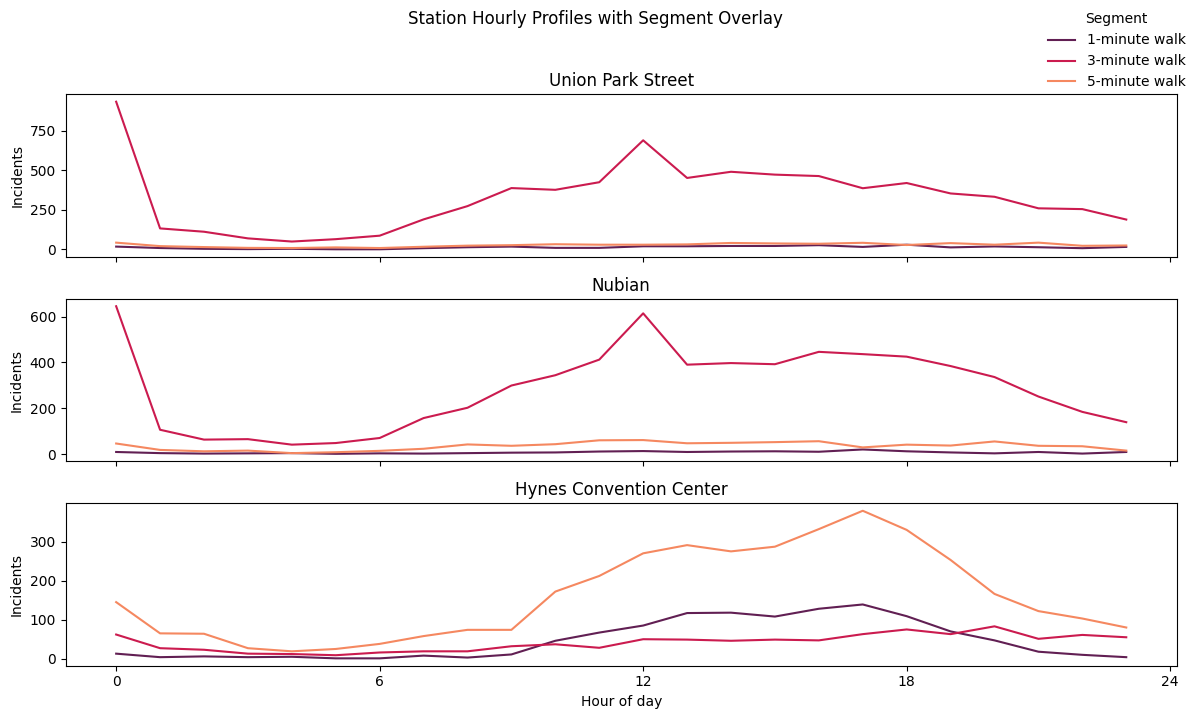

In [ ]:
df = all_crime_data_clean.copy()
ring_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk"}
df = df[df["walk_segment"].isin(ring_map.keys())].copy()
df["segment"] = df["walk_segment"].map(ring_map)

priority = df.groupby("station_owner").size().sort_values(ascending=False).head(3).index.tolist()

seg_order = ["1-minute walk","3-minute walk","5-minute walk"]
pal = sns.color_palette("rocket", 3)
seg_colors = dict(zip(seg_order, pal))

fig, axes = plt.subplots(len(priority), 1, figsize=(12,7), sharex=True)

for ax, st in zip(axes, priority):
    prof = (df[df["station_owner"]==st]
              .groupby(["segment","HOUR"]).size()
              .unstack(fill_value=0)
              .reindex(index=seg_order, fill_value=0))

    for seg in seg_order:
        ax.plot(range(24), prof.loc[seg].values, label=seg, color=seg_colors[seg])
    ax.set_title(st)
    ax.set_ylabel("Incidents")
    ax.set_xticks(range(0, 25, 6))
    ax.set_xticklabels([str(h) for h in range(0, 25, 6)])

axes[-1].set_xlabel("Hour of day")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Segment", loc="upper right", frameon=False)
fig.suptitle("Station Hourly Profiles with Segment Overlay", y=1.02)
plt.tight_layout()
plt.show()

This figure compares 24-hour profiles for priority stations to see whether peak windows shift with catchment size.
*   Union Park Street and Nubian sustain mid-day through evening activity in the 3 minute ring, consistent with mixed commercial and transit use.
*   Hynes Convention Center peaks later and shows the strongest curve in the 5 minute ring, suggesting the surrounding district drives the profile.
*   The 1 minute ring contributes a smaller but stable share across hours.

next analysis shows how offense types concentrate near transit stations compared with outside areas.
* tilt index=segment share/outside share
* The tilt index (>1) indicates over-representation near
stations.

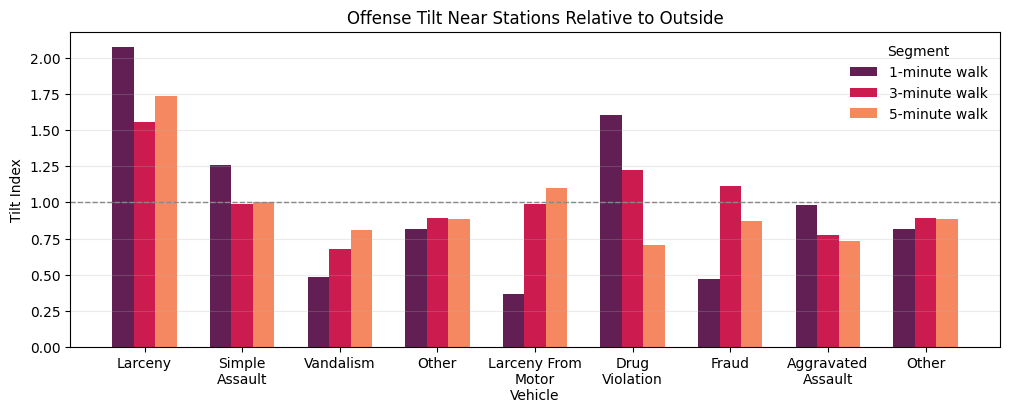

In [ ]:
df = all_crime_data_clean.copy()
df["OFFENSE_CODE_GROUP"] = df["OFFENSE_CODE_GROUP"].fillna("Unknown")
seg_map = {"1.0":"1-minute walk","3.0":"3-minute walk","5.0":"5-minute walk","outside":"Outside"}
df = df[df["walk_segment"].isin(seg_map.keys())].copy()
df["segment"] = df["walk_segment"].map(seg_map)

top_off = (df.groupby("OFFENSE_CODE_GROUP").size()
             .sort_values(ascending=False).head(8).index.tolist())
df["OFFENSE_TOP"] = np.where(df["OFFENSE_CODE_GROUP"].isin(top_off), df["OFFENSE_CODE_GROUP"], "Other")

tab = (df.groupby(["segment","OFFENSE_TOP"]).size()
         .unstack(fill_value=0)
         .reindex(index=["1-minute walk","3-minute walk","5-minute walk","Outside"], fill_value=0)
         .reindex(columns=top_off + ["Other"], fill_value=0))

seg_share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0)
outside = seg_share.loc["Outside"].replace(0, np.nan)
tilt = seg_share.loc[["1-minute walk","3-minute walk","5-minute walk"]].div(outside, axis=1)

seg_order = ["1-minute walk","3-minute walk","5-minute walk"]
pal = sns.color_palette("rocket", 3)
seg_colors = dict(zip(seg_order, pal))


cats = [textwrap.fill(c, 12) for c in tilt.columns.tolist()]
x = np.arange(len(cats)); w = 0.22

fig, ax = plt.subplots(figsize=(12,5))
for i, seg in enumerate(seg_order):
    ax.bar(x + (i-1)*w, tilt.loc[seg].values, width=w, color=seg_colors[seg], label=seg)

ax.axhline(1.0, linestyle="--", color="#888888", linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_ylabel("Tilt Index")
ax.set_title("Offense Tilt Near Stations Relative to Outside")
ax.legend(title="Segment", frameon=False)
ax.grid(axis="y", alpha=0.25)

plt.subplots_adjust(bottom=0.25)
plt.show()

This figure shows which offense types are disproportionately near stations using a tilt index.
*   Larceny tilts strongly toward stations, indicating high concentration of petty theft near immediate station surroundings.
*   Drug Violations also lean toward station areas, while Vandalism, fraud and Aggravated Assault are relatively less concentrated near the core.
*   Larceny from Motor Vehicle strengthens at 3 to 5 minutes, aligning with parking and curb activity outside the immediate platform area.

Next is a consolidated map shows crime counts within 5-minutes walk distance. Each station is a point; marker size scales with incident counts, and a light basemap provides context.

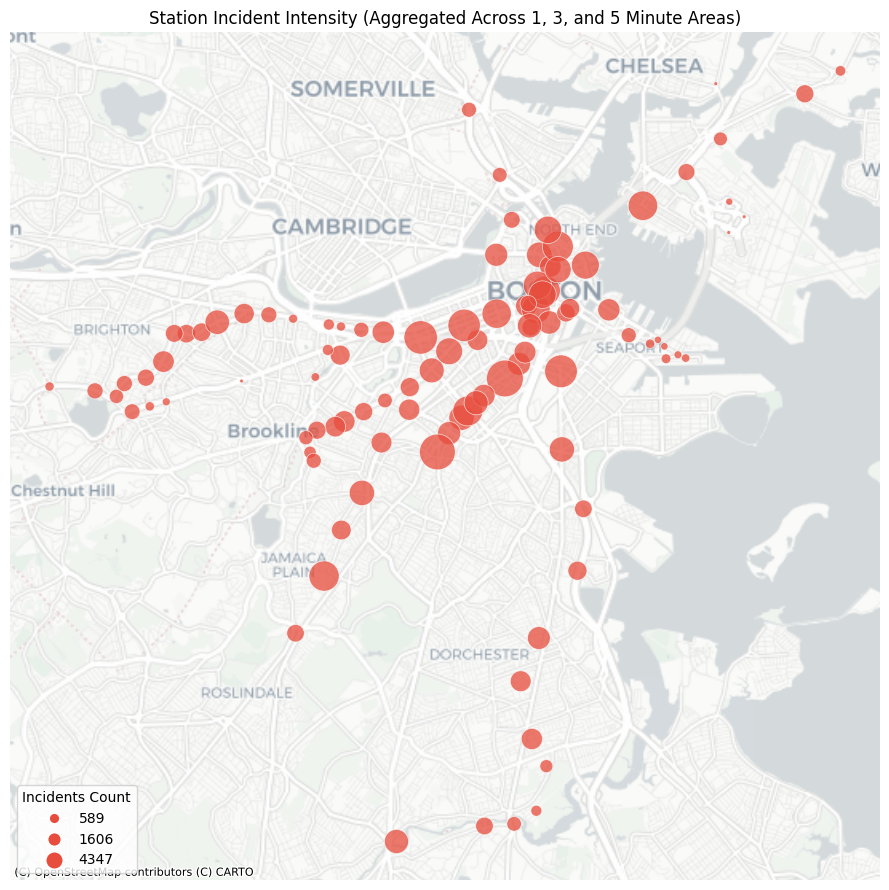

41.7% of all incidents fall within 1, 3, or 5-minute station areas.


In [ ]:
df1 = (all_crime_data_clean
       .dropna(subset=["station_owner", "walk_segment"])
       .assign(station_owner_norm=lambda d: d["station_owner"].str.strip()))

sd1 = stations_data.assign(STATION_norm=lambda d: d["STATION"].str.strip())
coords = sd1.drop_duplicates("STATION_norm")[["STATION_norm","lon","lat"]]

cnt_all = (df1.groupby("station_owner_norm").size()
             .rename("count").reset_index()
             .merge(coords, left_on="station_owner_norm", right_on="STATION_norm", how="left")
             .dropna(subset=["lon","lat"]))

gdf1 = gpd.GeoDataFrame(
    cnt_all, geometry=gpd.points_from_xy(cnt_all.lon, cnt_all.lat), crs="EPSG:4326"
).to_crs(3857)

smax = gdf1["count"].max()
gdf1["size"] = 700 * np.sqrt(gdf1["count"] / smax)

fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(gdf1.geometry.x, gdf1.geometry.y,
           s=gdf1["size"], color="#E74C3C", edgecolor="white", linewidth=0.5, alpha=0.75)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=gdf1.crs.to_string())
ax.set_axis_off()
ax.set_title("Station Incident Intensity (Aggregated Across 1, 3, and 5 Minute Areas)")

qs = np.quantile(gdf1["count"], [0.5, 0.75, 0.95])
sizes = 700 * np.sqrt(qs / smax)
handles = [Line2D([0],[0], marker='o', color='w', label=f"{int(q)}",
                  markerfacecolor="#E74C3C", markersize=np.sqrt(s/np.pi)) for q, s in zip(qs, sizes)]
ax.legend(handles=handles, title="Incidents Count", loc="lower left", frameon=True)

plt.tight_layout(); plt.show()

pct = 100 * len(df1[df1["walk_segment"].isin(["1.0","3.0","5.0"])]) / len(all_crime_data_clean)
print(f"{pct:.1f}% of all incidents fall within 1, 3, or 5-minute station areas.")

## 3.4 Police Districts Analysis in Relation to MBTA and Crimes

*How does crime concentration vary by district?*

We compare police districts hotspots using normalized station‑adjacent incident densities.


This chapter looks at crimes near MBTA stations by police district. First, we measure what share of each district’s crimes happen within the 5-minute MBTA isochrone. Then, we show how those shares change over time.

This figure shows, by police district, what share of all reported incidents happened within a 5-minute MBTA walkshed. Bars rank districts by this “station-adjacent” share, with labels showing the percentage. The table below the chart lists the underlying counts and shares.

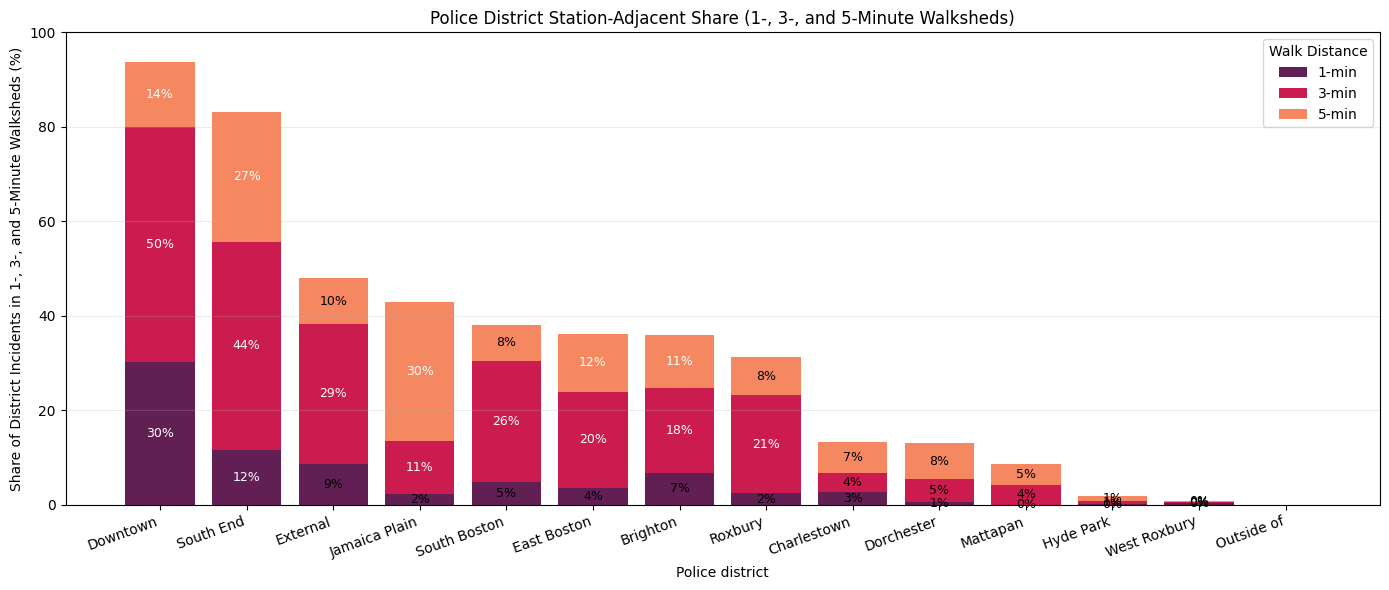

     District  All incidents   1-min   3-min   5-min  1-min (%)  3-min (%)  5-min (%)  ≤5-min total (%)
     Downtown          38151 11525.0 18955.0  5275.0       30.2       49.7       13.8              93.7
    South End          49652  5810.0 21853.0 13599.0       11.7       44.0       27.4              83.1
     External            217    19.0    64.0    21.0        8.8       29.5        9.7              47.9
Jamaica Plain          16698   397.0  1855.0  4933.0        2.4       11.1       29.5              43.0
 South Boston          25298  1218.0  6505.0  1933.0        4.8       25.7        7.6              38.2
  East Boston          12838   466.0  2598.0  1589.0        3.6       20.2       12.4              36.2
     Brighton          19933  1353.0  3563.0  2254.0        6.8       17.9       11.3              36.0
      Roxbury          42658  1049.0  8838.0  3435.0        2.5       20.7        8.1              31.2
  Charlestown           5799   154.0   233.0   384.0        2.7 

In [ ]:
df = all_crime_data_clean.copy()
df = df[df["DISTRICT"].notna()].copy()

std = (df["DISTRICT"].astype(str)
                   .str.upper()
                   .str.replace(r"[^A-Z0-9]", "", regex=True))
name_map = {
    "A1":  "Downtown",
    "A15": "Charlestown",
    "A7":  "East Boston",
    "B2":  "Roxbury",
    "B3":  "Mattapan",
    "C6":  "South Boston",
    "C11": "Dorchester",
    "D4":  "South End",
    "D14": "Brighton",
    "E5":  "West Roxbury",
    "E13": "Jamaica Plain",
    "E18": "Hyde Park",
}
df = df.assign(DISTRICT_STD=std,
               DISTRICT_NAME=std.map(name_map).fillna(df["DISTRICT"]))

segments = ["1.0","3.0","5.0"]
labels = {"1.0":"1-min","3.0":"3-min","5.0":"5-min"}

all_inc = df.groupby("DISTRICT_NAME").size().rename("All incidents")
seg_counts = (df[df["walk_segment"].isin(segments)]
              .groupby(["DISTRICT_NAME","walk_segment"])
              .size()
              .unstack(fill_value=0)
              .reindex(columns=segments, fill_value=0))
seg_counts.columns = [labels[c] for c in seg_counts.columns]

tab = pd.concat([all_inc, seg_counts], axis=1).fillna(0).astype({"All incidents":int})
for c in ["1-min","3-min","5-min"]:
    tab[f"{c} (%)"] = np.where(tab["All incidents"]>0, 100*tab[c]/tab["All incidents"], np.nan)

tab["≤5-min total (%)"] = tab[["1-min (%)","3-min (%)","5-min (%)"]].sum(axis=1)
order = tab.sort_values("≤5-min total (%)", ascending=False).index
tab = tab.loc[order]

x = np.arange(len(tab))
palette = sns.color_palette("rocket", 3)
fig, ax = plt.subplots(figsize=(14,6))

v1 = tab["1-min (%)"].to_numpy()
v3 = tab["3-min (%)"].to_numpy()
v5 = tab["5-min (%)"].to_numpy()

b0 = np.zeros(len(tab))
bars1 = ax.bar(tab.index, v1, bottom=b0, label="1-min", color=palette[0])
b1 = b0 + np.nan_to_num(v1)
bars3 = ax.bar(tab.index, v3, bottom=b1, label="3-min", color=palette[1])
b2 = b1 + np.nan_to_num(v3)
bars5 = ax.bar(tab.index, v5, bottom=b2, label="5-min", color=palette[2])

for i, v in enumerate(v1):
    if np.isfinite(v) and v > 0:
        ax.text(i, b0[i] + v/2, f"{v:.0f}%", ha="center", va="center",
                fontsize=9, color=("white" if v >= 10 else "black"))
for i, v in enumerate(v3):
    if np.isfinite(v) and v > 0:
        ax.text(i, b1[i] + v/2, f"{v:.0f}%", ha="center", va="center",
                fontsize=9, color=("white" if v >= 10 else "black"))
for i, v in enumerate(v5):
    if np.isfinite(v) and v > 0:
        ax.text(i, b2[i] + v/2, f"{v:.0f}%", ha="center", va="center",
                fontsize=9, color=("white" if v >= 10 else "black"))

ax.set_ylim(0, 100)
ax.set_ylabel("Share of District Incidents in 1-, 3-, and 5-Minute Walksheds (%)")
ax.set_xlabel("Police district")
ax.set_title("Police District Station-Adjacent Share (1-, 3-, and 5-Minute Walksheds)")
ax.grid(axis="y", alpha=0.25)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right")
ax.legend(title="Walk Distance")
plt.tight_layout()
plt.show()

out = tab.reset_index().rename(columns={"DISTRICT_NAME":"District"})
cols = ["District","All incidents","1-min","3-min","5-min","1-min (%)","3-min (%)","5-min (%)","≤5-min total (%)"]
for c in ["1-min (%)","3-min (%)","5-min (%)","≤5-min total (%)"]:
    out[c] = out[c].round(1)
print(out[cols].to_string(index=False))

Downtown and South End are the most transit-centric: most incidents occur within a 3-minute walkshed (Downtown 80% within ≤3 min, South End 56% within ≤3 min), with Downtown also showing a very large 1-minute core (~30%). Jamaica Plain and South Boston skew to the 5-minute ring, meaning issues concentrate on approaches rather than right at stations. Outer districts (Dorchester, Mattapan, Hyde Park, West Roxbury) are far less transit-driven.
*   Core posts (≤3 min): Put fixed posts and peak-hour coverage around Downtown and South End stations/egress routes; Downtown in particular needs visibility within the 1-minute core.
*   Perimeter patrols (3–5 min): In Jamaica Plain and South Boston, shift resources to last-mile corridors (lighting, cameras, bike/roving units) where the 5-minute share dominates.
*   Neighborhood-first: In Dorchester, Mattapan, Hyde Park, West Roxbury, focus on non-station hotspots; transit walksheds account for a small share of each district’s total.

This figure shows, by police district, what share of incidents occurred within the 5-minute MBTA walkshed. Bars rank districts by this station-adjacent share; the table lists counts and percentages.

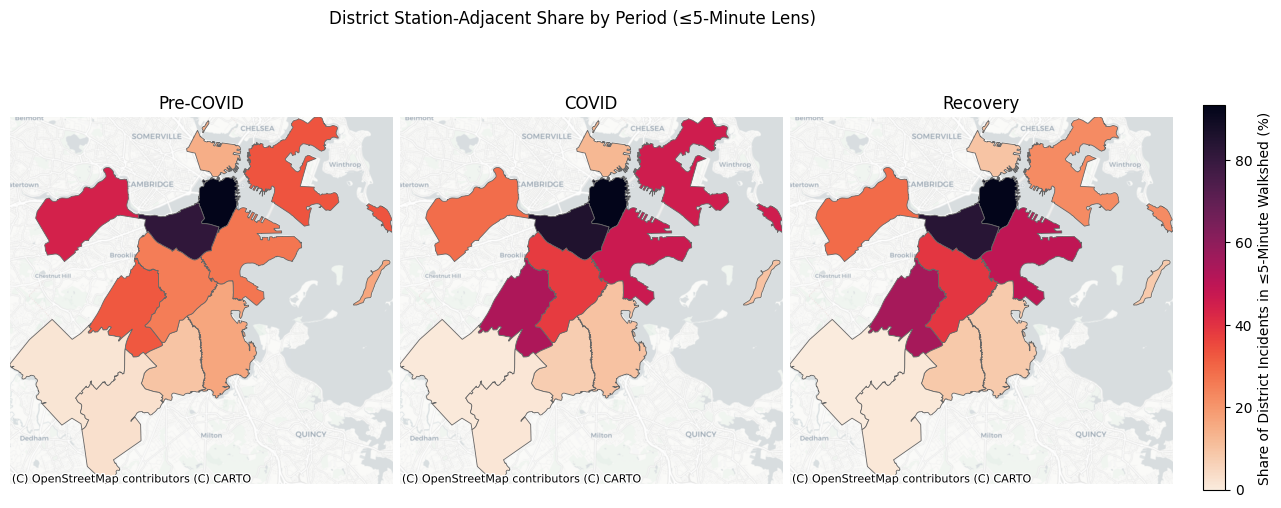

Pivot: ≤5-minute share (%) by district × period
Period    Pre-COVID  COVID  Recovery
DISTRICT                            
A1             93.0   93.9      95.8
A15            14.6   12.5       9.6
A7             33.3   45.5      22.5
B2             25.4   38.1      39.0
B3              9.5    7.4       8.7
C11            16.5   10.2       8.1
C6             26.7   46.9      49.3
D14            44.2   28.7      28.9
D4             81.5   85.4      83.0
E13            32.6   53.5      54.6
E18             2.7    1.3       1.0
E5              1.6    0.5       0.0

Pivot: counts by district × period (all_inc, in_le5)
           all_inc                    in_le5                
         Pre-COVID  COVID Recovery Pre-COVID  COVID Recovery
DISTRICT                                                    
A1           19232  13177     5742     17883  12374     5498
A15           3106   2028      665       453    254       64
A7            5911   4880     2047      1971   2222      460
B2           2

In [ ]:
df = all_crime_data_clean.copy()
df = df[df["DISTRICT"].notna()].copy()

def period(y):
    if 2016<=y<=2019: return "Pre-COVID"
    if 2020<=y<=2023: return "COVID"
    if 2024<=y<=2025: return "Recovery"
    return np.nan

df["Period"] = df["YEAR"].apply(period)
df = df[df["Period"].notna()].copy()

den = df.groupby(["DISTRICT","Period"]).size().rename("all_inc").reset_index()
num = (df[df["walk_segment"].isin({"1.0","3.0","5.0"})]
       .groupby(["DISTRICT","Period"]).size()
       .rename("in_le5").reset_index())
tab = (pd.merge(den, num, on=["DISTRICT","Period"], how="left")
         .fillna({"in_le5":0})
         .assign(pct=lambda x: np.where(x["all_inc"]>0, 100*x["in_le5"]/x["all_inc"], np.nan)))

gpol = police_polygons.to_crs("EPSG:4326").copy()
tab = tab[tab["DISTRICT"].isin(gpol["DISTRICT"])].copy()
joined = gpol.merge(tab, on="DISTRICT", how="left").to_crs(3857)

periods = ["Pre-COVID","COVID","Recovery"]
vmax = np.nanpercentile(joined["pct"].values, 95) if np.isfinite(joined["pct"]).any() else 100
xmin, ymin, xmax, ymax = joined.total_bounds

fig, axes = plt.subplots(1, 3, figsize=(15,6), sharex=True, sharey=True)
plt.subplots_adjust(right=0.90, wspace=0.02)

for ax, per in zip(axes, periods):
    sub = joined[joined["Period"]==per]
    if len(sub):
        sub.plot(column="pct", ax=ax, cmap="rocket_r", vmin=0, vmax=vmax,
                 linewidth=0.6, edgecolor="#666666", legend=False)
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
                       crs=sub.crs.to_string(), alpha=0.9)
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal"); ax.set_title(per); ax.set_axis_off()

cax = fig.add_axes([0.92, 0.18, 0.015, 0.64])
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Share of District Incidents in ≤5-Minute Walkshed (%)")

fig.suptitle("District Station-Adjacent Share by Period (≤5-Minute Lens)", y=0.98)
plt.show()

pt_pct = (tab.pivot(index="DISTRICT", columns="Period", values="pct")
            .reindex(columns=periods)
            .round(1))

pt_counts = (tab.pivot(index="DISTRICT", columns="Period", values=["all_inc","in_le5"])
               .reindex(columns=pd.MultiIndex.from_product([["all_inc","in_le5"], periods]))
               .fillna(0).astype(int))

print("Pivot: ≤5-minute share (%) by district × period")
print(pt_pct.to_string())

print("\nPivot: counts by district × period (all_inc, in_le5)")
print(pt_counts.to_string())

These maps show, for each period, the share of each district’s incidents that happened within the MBTA ≤5-minute walkshed (segments 1.0, 3.0, 5.0). Darker color means a higher station-adjacent share.
*   Transit cores. Downtown (A1) stays very transit focused at about 93–96% across periods (Recovery: 5,498 of 5,742). South End (D4) is also high at about 82–85% (Recovery: 7,127 of 8,582). Keep fixed posts at stations and at immediate exits.
*   Rising exposure since COVID. South Boston (C6) increases 26.7% → 46.9% → 49.3%. Jamaica Plain (E13) rises 32.6% → 53.5% → 54.6%. Roxbury (B2) rises 25.4% → 38.1% → 39.0%. Prioritize 3 to 5 minute approach corridors and peak hours in these districts. East Boston (A7) jumps during COVID (33.3% → 45.5%) then falls in Recovery (22.5%), which suggests demand moved back off station.
*   Low or declining station influence. Dorchester (C11) drops 16.5% → 10.2% → 8.1%. Charlestown (A15) drops 14.6% → 12.5% → 9.6%. Brighton (D14) falls from 44.2% to about 29% since COVID. Mattapan (B3) stays in single digits. West Roxbury (E5) and Hyde Park (E18) remain near zero. Focus resources on off-station hotspots in these areas.

This figure maps incident density per square kilometer within the 5-minute lens by district, highlighting where station-adjacent activity concentrates after normalizing by area.

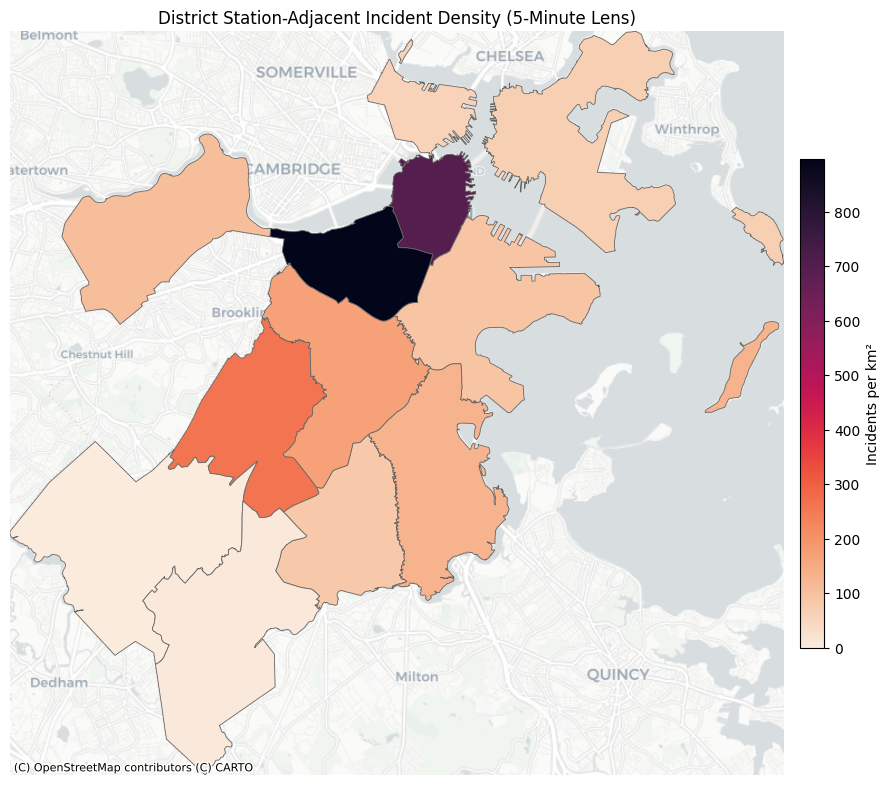

In [ ]:
df = all_crime_data_clean.copy()
df = df[(df["walk_segment"]=="5.0") & df["DISTRICT"].notna()].copy()

g = police_polygons.to_crs(3857).copy()
g["area_km2"] = g.geometry.area/1e6

counts = df.groupby("DISTRICT").size().rename("count").reset_index()
g = g.merge(counts, on="DISTRICT", how="left").fillna({"count":0})
g["density_km2"] = np.where(g["area_km2"]>0, g["count"]/g["area_km2"], np.nan)

vmax = np.nanpercentile(g["density_km2"].values, 95) if np.isfinite(g["density_km2"]).any() else 1
xmin, ymin, xmax, ymax = g.total_bounds

fig, ax = plt.subplots(figsize=(9,9))
g.plot(column="density_km2", ax=ax, cmap="rocket_r", vmin=0, vmax=vmax, linewidth=0.6, edgecolor="#666666", legend=False)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=g.crs.to_string(), alpha=0.9)
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.set_aspect("equal"); ax.set_axis_off()
ax.set_title("District Station-Adjacent Incident Density (5-Minute Lens)")

sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02, shrink=0.6, aspect=20)
cbar.set_label("Incidents per km²")
cbar.ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout(); plt.show()

This map shows how concentrated station-adjacent incidents are by district, normalized as incidents per km² within the ≤5-minute walkshed. Darker color means higher density inside the 5-minute lens.
*   Highest densities cluster in the core districts like Downtown and South End, which points to short, high-activity walksheds where fixed posts and peak-hour coverage pay off.
*   Midrange densities in Roxbury, Jamaica Plain, and South Boston suggest focusing on the 3 to 5 minute approach corridors and common station exit routes.
*   Outer districts show low density, so transit areas are not the main driver there; prioritize non-station hotspots and neighborhood problem locations.

# **4. Conclusion**


This study examined how crime concentrates around MBTA rapid-transit stations by linking Boston Police incidents with 1-, 3-, and 5-minute walksheds. Incidents declined between 2020 and 2023 and only partially rebounded afterward. About four in ten occur within five minutes, with the three-minute ring capturing the largest share. Larceny and theft are more common near stations, while serious violence shows weaker proximity patterns. Activity peaks from late morning through early evening on weekdays, following commuter and retail flow.

These findings suggest the three-minute walkshed contains most actionable, station-adjacent risk while diminishing returns appear beyond five minutes. Crowding, queues, and nearby retail likely shape the offense mix more than the station entrances themselves. Some limitations remain, including modest gaps in geocoding, approximate walking zones, and incomplete year-to-date data. Future analyses should adjust for ridership exposure, consider incident severity, and track repeat-location trends to refine priorities.

Efforts should focus on visible presence and theft prevention within three minutes of high-traffic hubs during weekday midday and evening peaks. Pair targeted environmental upgrades such as lighting, visibility, mezzanine design, and theft controls with simple dashboards that track incidents by station and time. Ongoing coordination between MBTA and BPD, documented follow-ups, and annual updates will ensure that safety interventions remain transparent, adaptive, and data-driven.

### Future steps

*   Targeted deployments: Prioritize fixed posts and peak-hour coverage at Downtown and South End stations; use roving or bike units along 3 to 5 minute approach corridors in South Boston, Jamaica Plain, and Roxbury. Track pre and post changes in counts and share.
*   Time and place pilots: Split results by hour and weekday to set patrol windows; pick three high-impact stations per priority district and run 8–12 week pilots with clear metrics.
*   Environment fixes: Audit lighting, sightlines, cameras, and curb space near station exits and along last-mile routes, especially where 5 minute shares are high.
*   Refine the view: Repeat the analysis by offense type, season, and line; add per-capita or foot-traffic proxies to separate exposure from risk; clean up residual “External” or “Outside” codes before publishing final charts.

# **5. Challenges**



* Incomplete / Missing Coordinates: About 5% of crime records lacked geocoded latitude and longitude values, making them unusable for spatial analysis. These were dropped, potentially underrepresenting some districts (e.g., A1, C6).

* Offense Code Inconsistencies: Some offenses had missing or mismatched OFFENSE_CODE_GROUP values. These were imputed using available records, but grouping accuracy might not be perfect.

* Reporting Biases in Source Data: Boston Police Department incident reports may reflect patterns of police activity and reporting practices rather than purely crime occurrence. For example, the weekday-hour heatmap shows a clear mid-day to early-evening concentration of reported incidents, especially around Wednesday afternoons. This pattern may partly result from reporting and patrol schedules, officers are more active and accessible during business hours, increasing the likelihood that incidents are logged.

* Temporal Coverage Bias: October 2025 data was excluded since the month was incomplete, meaning results for 2025 reflect only partial-year activity and are not directly comparable to full years.

# **6. References**

1. [Crime Incident Reports (Boston) — August 2015 to present](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system)  


2. [MassGIS — MBTA Rapid Transit data](https://www.mass.gov/info-details/massgis-data-mbta-rapid-transit)  


3. [Boston Police Districts dataset](https://data.boston.gov/dataset/police-districts)  


4. [Mapbox Navigation API — Isochrone](https://docs.mapbox.com/api/navigation/isochrone/)  


5. [Seaborn (Python visualization library) documentation](https://seaborn.pydata.org/)

# **7. Generative AI Disclosure**

*   ChatGPT was used selectively for writing and coding assistance, under full team validation and oversight.

*   Geospatial Coding: Provided sample code for GeoPandas operations, nearest station joins, CRS selection, and distance binning. All suggested code was executed on our dataset. Row counts were reconciled before and after joins, and distances were spot-checked against known station locations. Any errors were corrected by the team before use.

*   Offense Categorization: Suggested initial keyword rules for grouping offenses and helped draft a filtered offense code list. The team refined these classifications, removed misclassifications, and verified the resulting distributions against Boston Police Department labels and our expectations. The final rules and lists were implemented in a reproducible function.

*   Code Standardization: Supported style alignment across notebooks through consistent variable names, Pandas chaining, and proper .loc usage to avoid SettingWithCopy warnings. The unified notebook was run top to bottom to confirm clean execution, stable counts after merges, and consistent outputs.

*   Writing and Documentation: Assisted in improving grammar and tightening wording for documentation, analysis text, and conclusions. Every numeric claim was cross-checked with project tables and figures, and AI-edited text was retained only when it accurately reflected our findings.

*   Visualization Refinement: After chart types were selected, proposed clearer axis titles, legends, and consistent color schemes. All visuals were regenerated from our data, and scales and annotations were reviewed by the team.

*   Generative AI was used only for writing and coding assistance, not for deriving conclusions or interpreting data.